In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import librosa
from tqdm import tqdm_notebook as tqdm
import pickle
import IPython.display as ipd
from IPython.core.display import display, HTML, Javascript
import music21
import json, random
import guitarpro
%matplotlib inline

In [2]:
import keras
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [3]:
%run ../Utilities/Utilities.ipynb

In [4]:
%run ../Segmentation/Segmenter.ipynb

In [13]:
class sheet_generator:
    def __init__(self, note_model, string_model, segmentation_model=Segmenter(), bpm=None):
        """
        Create a sheet_generator object
        
        Args:
            note_model (str): Name of the NN model used for note identification
            string_model (str): Name of the NN model sued for string identification
            segmentation_model (object): Segmentation model
            bpm (int): Beats per minute
            
        """
        # Load prediction models
        self.note_model = load_NN(note_model, verbose=0)
        self.string_model = load_NN(string_model, verbose=0)
        self.segmentation_model = segmentation_model
        
        # Set bpm
        self.bpm = bpm
        
        # Create string-notes correspondence
        self.note_table = pd.read_csv("../Data/Piano/Note_table.tsv", header=0, sep="\t")
        self.start_8 = self.note_table[self.note_table["Note"] == "E1"].index[0]
        self.start_7 = self.note_table[self.note_table["Note"] == "B1"].index[0]
        self.start_6 = self.note_table[self.note_table["Note"] == "E2"].index[0]
        self.start_5 = self.note_table[self.note_table["Note"] == "A2"].index[0]
        self.start_4 = self.note_table[self.note_table["Note"] == "D3"].index[0]
        self.start_3 = self.note_table[self.note_table["Note"] == "G3"].index[0]
        self.start_2 = self.note_table[self.note_table["Note"] == "B3"].index[0]
        self.start_1 = self.note_table[self.note_table["Note"] == "E4"].index[0]
        self.string_notes = {
            "8": self.note_table["Note"].iloc[self.start_8:self.start_8+25].values,
            "7": self.note_table["Note"].iloc[self.start_7:self.start_7+25].values,
            "6": self.note_table["Note"].iloc[self.start_6:self.start_6+25].values,
            "5": self.note_table["Note"].iloc[self.start_5:self.start_5+25].values,
            "4": self.note_table["Note"].iloc[self.start_4:self.start_4+25].values,
            "3": self.note_table["Note"].iloc[self.start_3:self.start_3+25].values,
            "2": self.note_table["Note"].iloc[self.start_2:self.start_2+25].values,
            "1": self.note_table["Note"].iloc[self.start_1:self.start_1+25].values
        }
    
    def note_extraction(self, wave, show_plots):
        """
        Extract all notes from wave
        
        Args:
            wave (waveform): Input audio wave
            
        Returns:
            List: note predictions, with string, duration and fret info
            
        """
        onsets = list(map(int, self.segmentation_model.predict(wave, show_plots)))
        
        # For now we add the end of file as an extra onset
        onsets.append(len(wave.y))
        results = []
        
        for i in tqdm(range(len(onsets) - 1), leave=False):
            note = waveform(wave.y[onsets[i]:onsets[i+1]])
            
            if len(note.y) >= 500:
                # Predict note (chroma and octave)
                note_all_preds = self.note_model.predict(note.temp_data(500))
                note_confidence = np.max(note_all_preds)
                note_pred = librosa.midi_to_note(np.argmax(note_all_preds) + 28)

                # Predict string
                string_all_preds = self.string_model.predict(note.spectral_data(500, True))[0]
                string_confidence = np.max(string_all_preds)
                string_pred = np.argmax(string_all_preds) + 1
                
                # Calculate duration
                duration = len(note.y) / 8000
                
                while True:
                    try:
                        # Find corresponding fret
                        fret = self.find_fret(note_pred, string_pred)
                        break
                    except:
                        # Some string-note combinations are not possible
                        # This is due to an error in either note or string prediction (or both)
                        
                        # Note prediction error -> Pick next most likely note
                        if note_confidence < 0.1:
                            note_all_preds[note_all_preds == np.max(note_all_preds)] = 0
                            note_pred = librosa.midi_to_note(np.argmax(note_all_preds) + 28)
                            
                        # String prediction error -> Pick next most likely string
                        else:
                            string_all_preds[string_all_preds == np.max(string_all_preds)] = 0
                            string_pred = np.argmax(string_all_preds) + 1
                            
                results.append([note_pred, string_pred, duration, fret, string_confidence, string_all_preds])
        
        return results
    
    def find_fret(self, note, string):
        """
        Find corresponding fret given a note and a string
        
        Args:
            note (str): Note (chroma and octave)
            string (int): String number
            
        Returns:
            Int: Fret
        """
        return np.argwhere(self.string_notes[str(string)] == note)[0][0]
    
    def bpm_estimation(self, extracted_notes):
        """
        Estimate the bpm of an audio file given the extracted notes
        
        Args:
            extracted_notes (list): Note information extracted by the note_extraction method
            
        Returns:
            Int: bpm
            
        """
        extracted_notes = np.array(extracted_notes)
        return round_to_base(1/(2 * np.median(extracted_notes[:,2].astype(float))) * 60, 10)
    
    def raw_sheet(self, extracted_notes, apply_heuristics):
        """
        Generate a raw music sheet
        
        Args:
            extracted_notes (list): Note information extracted by the note_extraction method
            apply_heuristics (bool): Set to True to use heuristics to correct possible mistakes
            
        Returns:
            Array: Output sheet
            
        """
        extracted_notes = np.array(extracted_notes)
        
        if self.bpm is None:
            self.bpm = self.bpm_estimation(extracted_notes)
            
        # Round durations to sixteenth note duration
        extracted_notes[:,2] = round_to_base(extracted_notes[:,2].astype(float), 1/self.bpm * 60/4)
        extracted_notes = extracted_notes[extracted_notes[:,2].astype("float") > 0]
        
        if apply_heuristics:
            for i in range(extracted_notes.shape[0]):
                if i != 0:
                    # Heuristic 1 -> Change string if note is close to previous but fret is not
                    h1_cond1 = abs(librosa.note_to_midi(extracted_notes[i-1,0])-librosa.note_to_midi(extracted_notes[i,0])) < 4
                    h1_cond2 = abs(extracted_notes[i-1,3] - extracted_notes[i,3]) >= 5
                    if h1_cond1 and h1_cond2:
                        extracted_notes[i,1] = extracted_notes[i-1,1]
                        extracted_notes[i,3] = self.find_fret(extracted_notes[i,0], extracted_notes[i,1])
                
                # Heuristic 2 -> Change string if fret is far from previous and prediction confidence is not high
                h2_cond1 = abs(extracted_notes[i,3] - extracted_notes[i-1,3]) > 5
                h2_cond2 = extracted_notes[i,4] < 0.8
                if h2_cond1 and h2_cond2:
                    string_all_preds = extracted_notes[i,5]
                    string_all_preds[string_all_preds == np.max(string_all_preds)] = 0
                    extracted_notes[i,1] = np.argmax(string_all_preds) + 1
                    extracted_notes[i,3] = self.find_fret(extracted_notes[i,0], extracted_notes[i,1])
        
        return extracted_notes
    
    def display_tablature(self, sheet):
        """
        Generate a printable tab
        
        Args:
            sheet (array): Music sheet created by the raw_sheet method
            
        Returns:
            Str: Printable tab
            
        """
        tab = ""
        for string in range(1, 7):
            tab += self.string_notes[str(string)][0][0] + "  "
            for note in sheet:
                if int(note[1]) == string:
                    tab += str(note[3])
                else:
                    tab += "-" * len(str(note[3]))
                tab += "-"
            tab += "\n"
        print(tab)
        
    def create_guitarpro_tab(self, sheet):
        """
        Generate a guitarpro file from a music sheet
        
        Args:
            sheet (array): Music sheet created by the raw_sheet method
            file_name (str): Name of the output file
            
        Returns:
            None
            
        """
        # Create a blank gp5 structure from a template
        template = guitarpro.parse('blank.gp5')
        measure_list = template.tracks[0].measures
        del template.tracks[0].measures[0].voices[0].beats[0]
        bar_start = 0
        current_measure = 0
        
        for i in range(len(sheet)):
            # Check if previous notes and current fit in the same bar
            if (self.bpm/60) * (sheet[bar_start:i+1,2].astype("float").sum()) <= 4:
                duration = guitarpro.Duration(value= int(round(4/((self.bpm/60) * (float(sheet[i,2]))))))
                new_beat = guitarpro.Beat(template.tracks[0].measures[0].voices[0], duration=duration)
                new_note = guitarpro.Note(new_beat, value=int(sheet[i,3]), string=int(sheet[i,1]), 
                                          type=guitarpro.NoteType.normal)
                new_beat.notes.append(new_note)
                template.tracks[0].measures[current_measure].voices[0].beats.append(new_beat)
            else:
                # Check if previous notes fill up the bar entirely or if there's space left
                if (self.bpm/60) * (sheet[bar_start:i,2].astype("float").sum()) == 4:
                    current_measure += 1
                    new_measure = guitarpro.Measure(template.tracks[0], header=template.tracks[0].measures[0].header)
                    duration = guitarpro.Duration(value= int(round(4/((self.bpm/60) * (float(sheet[i,2]))))))
                    new_beat = guitarpro.Beat(template.tracks[0].measures[0].voices[0], duration=duration)
                    new_note = guitarpro.Note(new_beat, value=int(sheet[i,3]), string=int(sheet[i,1]), 
                                              type=guitarpro.NoteType.normal)
                    new_beat.notes.append(new_note)
                    new_measure.voices[0].beats.append(new_beat)
                    measure_list.append(new_measure)
                    bar_start = i
                else:
                    # Split the new note into beats that fit the bar and the remaining
                    fitting_beats = 4 - (self.bpm/60) * (sheet[bar_start:i,2].astype("float").sum())
                    duration = guitarpro.Duration(value= int(round(4/fitting_beats)))
                    new_beat = guitarpro.Beat(template.tracks[0].measures[0].voices[0], duration=duration)
                    new_note = guitarpro.Note(new_beat, value=int(sheet[i,3]), string=int(sheet[i,1]), 
                                              type=guitarpro.NoteType.normal)
                    new_beat.notes.append(new_note)
                    template.tracks[0].measures[current_measure].voices[0].beats.append(new_beat)
                    
                    remaining_beats = (self.bpm/60) * (float(sheet[i,2])) - fitting_beats
                    current_measure += 1
                    new_measure = guitarpro.Measure(template.tracks[0], header=template.tracks[0].measures[0].header)
                    duration = guitarpro.Duration(value= int(round(4/remaining_beats)))
                    new_beat = guitarpro.Beat(template.tracks[0].measures[0].voices[0], duration=duration)
                    new_note = guitarpro.Note(new_beat, value=int(sheet[i,3]), string=int(sheet[i,1]), 
                                              type=guitarpro.NoteType.tie)
                    new_beat.notes.append(new_note)
                    new_measure.voices[0].beats.append(new_beat)
                    measure_list.append(new_measure)
                    bar_start = i
                    
            print(i,duration.value, (self.bpm/60) * (float(sheet[i,2])))
        
        guitarpro.write(template, 'final.gp5')
    
    def display_music_sheet(self, sheet, play_audio=False):
        stream1 = music21.stream.Stream()
        instrument = music21.instrument.ElectricGuitar()
        instrument.partName = "Guitar"
        stream1.append(instrument)
        
        for i in range(len(sheet)):
            current_note = music21.note.Note(sheet[i,0])
            current_note.quarterLength = (self.bpm/60) * (float(sheet[i,2]))
            stream1.append(current_note)
        
        if play_audio:
            stream1.show("midi")
        
        fp = stream1.write('midi', fp='test.mid')
            
        self.showScore(stream1)
        
    def showScore(self, score):
        xml = open(score.write('musicxml')).read()
        self.showMusicXML(xml)
        
    def showMusicXML(self, xml):
        DIV_ID = "OSMD-div-"+str(random.randint(0,1000000))
        print("DIV_ID", DIV_ID)
        display(HTML('<div id="'+DIV_ID+'">loading OpenSheetMusicDisplay</div>'))

        print('xml length:', len(xml))

        script = """
        console.log("loadOSMD()");
        function loadOSMD() { 
            return new Promise(function(resolve, reject){

                if (window.opensheetmusicdisplay) {
                    console.log("already loaded")
                    return resolve(window.opensheetmusicdisplay)
                }
                console.log("loading osmd for the first time")
                // OSMD script has a 'define' call which conflicts with requirejs
                var _define = window.define // save the define object 
                window.define = undefined // now the loaded script will ignore requirejs
                var s = document.createElement( 'script' );
                s.setAttribute( 'src', "https://cdn.jsdelivr.net/npm/opensheetmusicdisplay@0.3.1/build/opensheetmusicdisplay.min.js" );
                //s.setAttribute( 'src', "/custom/opensheetmusicdisplay.js" );
                s.onload=function(){
                    window.define = _define
                    console.log("loaded OSMD for the first time",opensheetmusicdisplay)
                    resolve(opensheetmusicdisplay);
                };
                document.body.appendChild( s ); // browser will try to load the new script tag
            }) 
        }
        loadOSMD().then((OSMD)=>{
            console.log("loaded OSMD",OSMD)
            var div_id = "{{DIV_ID}}";
                console.log(div_id)
            window.openSheetMusicDisplay = new OSMD.OpenSheetMusicDisplay(div_id);
            openSheetMusicDisplay
                .load({{data}})
                .then(
                  function() {
                    console.log("rendering data")
                    openSheetMusicDisplay.render();
                  }
                );
        })
        """.replace('{{DIV_ID}}',DIV_ID).replace('{{data}}',json.dumps(xml))
        display(Javascript(script))
        return DIV_ID

In [14]:
SG = sheet_generator("../Single_note_models/Guitar/Guitar", "../Single_note_models/Guitar/Guitar_norm_string", bpm=120)

F#3 5 0.99908745
F#3 5 0.98992467
G#3 5 0.97542113
A3 5 0.85906243
G#3 5 0.9677848
F#3 5 0.9223146
E3 5 0.9810095
E3 5 0.9725782
D#3 5 0.8903911
E3 5 0.96895224


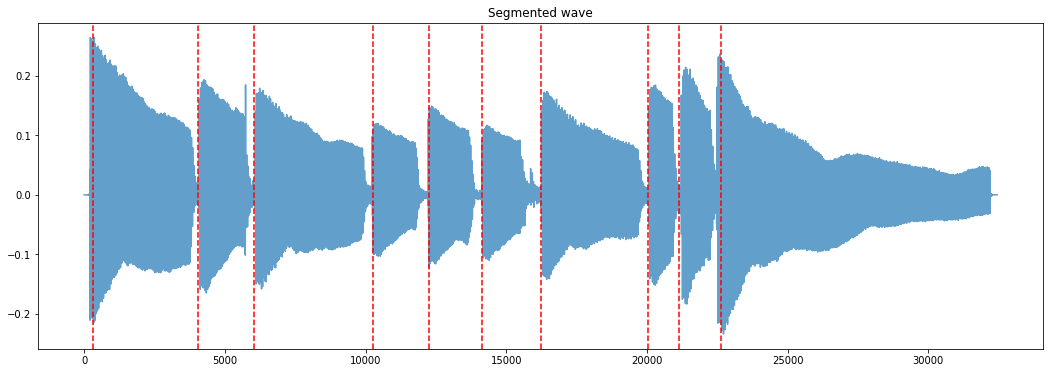

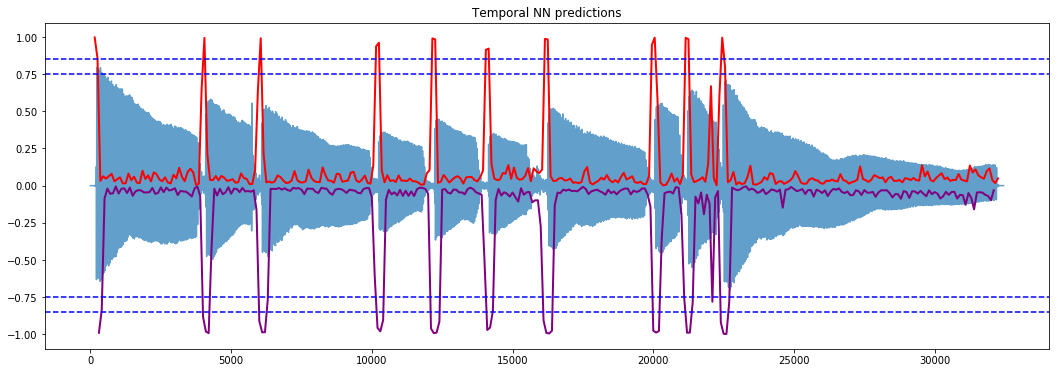

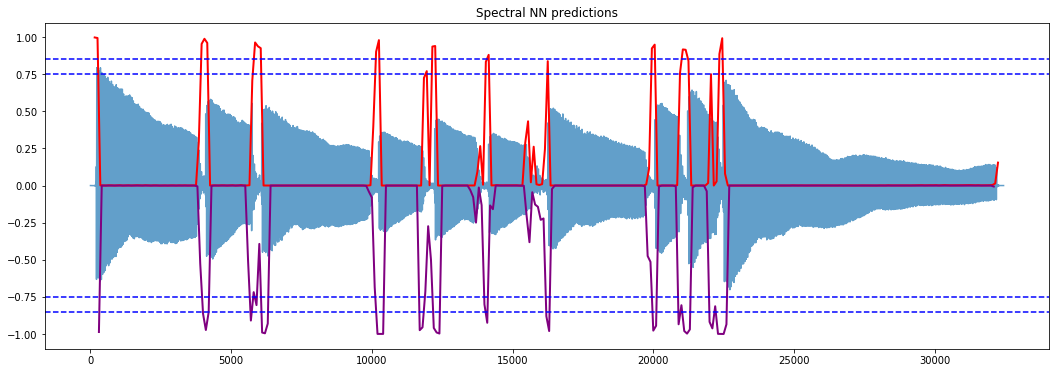

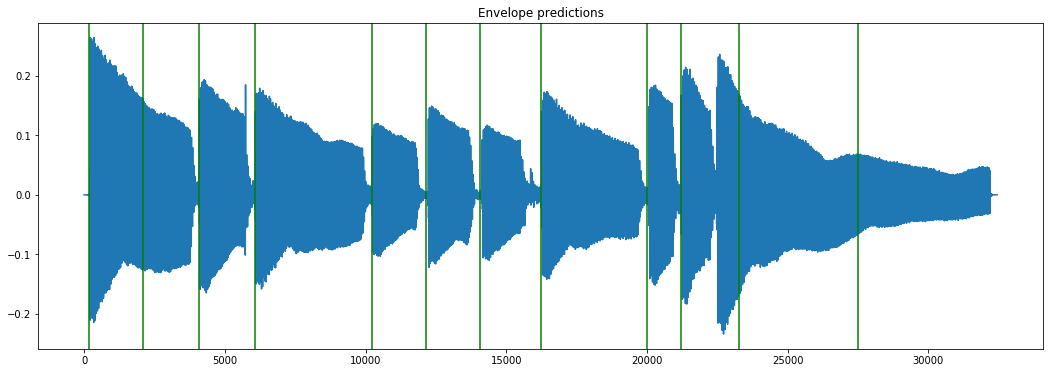

In [7]:
results = SG.note_extraction(waveform("../Samples/Guitar/Riffs/Guitar_noamp_riff1_2.mp3"), True)

In [8]:
results

[['F#3',
  5,
  0.46875,
  9,
  0.9451805,
  array([2.7612987e-04, 2.1554015e-03, 2.1440519e-03, 5.0067056e-02,
         9.4518048e-01, 1.7693642e-04, 7.1223266e-10, 3.3905484e-10],
        dtype=float32)],
 ['F#3',
  5,
  0.25,
  9,
  0.9804802,
  array([4.5015968e-04, 5.9379698e-03, 9.1273471e-04, 1.2216769e-02,
         9.8048019e-01, 2.2496063e-06, 6.1417482e-10, 7.2072390e-11],
        dtype=float32)],
 ['G#3',
  5,
  0.525,
  11,
  0.9998443,
  array([5.3913396e-08, 3.1849200e-07, 1.5287093e-04, 2.3520251e-06,
         9.9984431e-01, 1.1641429e-07, 2.0316077e-10, 8.4548856e-13],
        dtype=float32)],
 ['A3',
  5,
  0.25,
  12,
  0.99995863,
  array([6.54545644e-08, 3.84138552e-08, 2.21623686e-05, 4.64183586e-06,
         9.99958634e-01, 1.43664065e-05, 3.91177473e-08, 7.25043714e-09],
        dtype=float32)],
 ['G#3',
  5,
  0.2375,
  11,
  0.99817705,
  array([4.8051390e-07, 3.7844902e-06, 1.6967753e-03, 1.1955651e-04,
         9.9817705e-01, 2.3904565e-06, 4.3661381e-09, 1.2

In [15]:
sheet = SG.raw_sheet(results, True)

In [17]:
SG.display_tablature(sheet)

E  -----------------------
B  -----------------------
G  -----------------------
D  -----------------------
A  9-9-11-12-11-9-7-7-6-7-
E  -----------------------



In [18]:
SG.create_guitarpro_tab(sheet)

0 4 1.0
1 8 0.5
2 4 1.0
3 8 0.5
4 8 0.5
5 8 0.5
6 4 1.0
7 16 0.25
8 8 0.5
9 16 2.5
